# Analysis of extreme climate events

We study the problem of drawing reliable conclusions about the winner: $\hat{\imath} = \underset{i\in[m]}{\text{argmax}} \ X_i$, where $X_1,\dots,X_m$ are $m$ competing candidates.


In this notebook, we study inference on extreme climate events: warmest/coldest days and locations on Earth. We use climate data from WeatherBench [1]. We use the ClimateLearn package [2] to access the data. The dataset contains hourly measurements of temperature across a discrete grid of locations on Earth. The grid is obtained by pairing 32 latitude coordinates with 64 longitude coordinates.

[1] Rasp, S., Dueben, P. D., Scher, S., Weyn, J. A., Mouatadid, S., & Thuerey, N. (2020). WeatherBench: A Benchmark Data Set for Data‐Driven Weather Forecasting. Journal of Advances in Modeling Earth Systems, 12(11).

[2] Nguyen, T., Jewik, J., Bansal, H., Sharma, P., Grover, A. (2024). ClimateLearn: Benchmarking Machine Learning for Weather and Climate Modeling. NeurIPS.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import pandas as pd
from climate_learn.data import download
import scipy.stats as stats
from climate_learn.utils.data import load_dataset, view
from scipy.stats import norm

from methods import *
from utils import *

/Users/tijanazrnic/miniconda3/envs/lsi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data processing

In [2]:
# Make cache
cache = './.cache'
os.makedirs(cache, exist_ok=True)
# Download data
#download(root = cache, source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")
dataset = load_dataset("../lsi/" + cache + "/data/weatherbench/era5/5.625/2m_temperature")
view(dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [3]:
df = dataset.to_dataframe()
temps = df.groupby(["time"]).mean()
times = temps.reset_index()["time"].to_numpy().astype(str)
idx = np.bitwise_not(np.array(["-02-29" in x for x in times]))
temps_proc = temps[idx]
samples_per_year = 365*24
samples = [ temps_proc[year*samples_per_year:(year+1)*samples_per_year].to_numpy() for year in range(0, int(temps_proc.shape[0]/samples_per_year)) ]

## Inference on the warmest day

Inference on the coldest day is performed analogously, after selecting based on -X instead of X.

In [4]:
# split data into two chunks (for inference and covariance estimation)
n_cov = 20
n = len(samples) - n_cov

avg_temp = np.stack(samples[n_cov:], axis=0).mean(axis=0)

# take one measurement per day (at noon). this code finds the right indices
daily_idx = np.linspace(11,8771,366)
daily_idx = [int(daily_idx[i]) for i in range(len(daily_idx) - 1)]
X = avg_temp[daily_idx].squeeze()
Sigma = np.cov(np.stack([samples[i][daily_idx] for i in range(n_cov)], axis=0).squeeze().T)/n
m = len(X)
ihat = np.argmax(X)
alpha = 0.1

In [5]:
# conditional inference
A, b = inference_on_winner_polyhedron(m, ihat)
eta = np.zeros(m)
eta[ihat] = 1
cond_int = conditional_inference(X, Sigma, A, b, eta, alpha=alpha)

# hybrid inference
beta = 0.01
hybrid_int = hybrid_inference(X, Sigma, A, b, eta, alpha=alpha, beta=beta)

# locally simultaneous inference
nu = 0.01
plausible_gap = 4*max_z_width(Sigma, nu)*np.sqrt(np.diag(Sigma))
LSI_int = locally_simultaneous_inference(X, Sigma, plausible_gap, alpha = alpha, nu = nu)

# fully simultaneous inference
SI_int = [X[ihat] - max_z_width(Sigma, alpha)*np.sqrt(np.diag(Sigma)[ihat]), X[ihat] + max_z_width(Sigma, alpha)*np.sqrt(np.diag(Sigma)[ihat])]

# zoom correction
zoom_int = zoom_grid(X, Sigma, alpha = alpha)

/Users/tijanazrnic/Code/better_lsi/methods.py:41: RuntimeWarning: invalid value encountered in double_scalars
  if num/denom < 1-alpha/2:


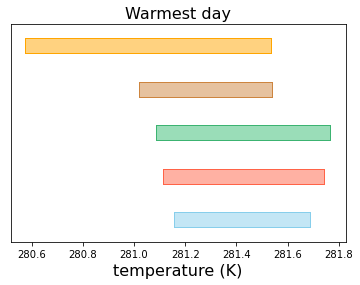

In [6]:
labels = ['conditional','hybrid','simultaneous','locally simultaneous','zoom']
plot_title = 'Warmest day'
xlabel = 'temperature (K)'
make_intervals([cond_int, hybrid_int, SI_int, LSI_int, zoom_int], labels, plot_title, xlabel, legend=False)
path = 'plots/warmest_day.pdf'
plt.savefig(path, bbox_inches='tight')

## Inference on the warmest location

Inference on the coldest location is performed analogously, after selecting based on -X instead of X.

In [7]:
dt_index = df.index.get_level_values(2)
df["year"] = dt_index.year
df.set_index("year", append=True)
yearly_temp_latlong = df.groupby(["lat", "lon", "year"]).mean().reset_index()
numpy_temps = yearly_temp_latlong[yearly_temp_latlong["year"] <= 1998].to_numpy()
years = range(1979, 1999)

In [8]:
n_cov = 20
n = len(samples) - n_cov
Sigma_data = np.zeros((2048, n_cov))
for i in range(20):
    indices = np.where(numpy_temps[:,2] == years[i])
    Sigma_data[:,i] = numpy_temps[indices,3]
Sigma = np.cov(Sigma_data)/n

mean_temps = yearly_temp_latlong[yearly_temp_latlong["year"] > 1998].set_index("year").groupby(["lat", "lon"]).mean().reset_index()
lat = mean_temps["lat"].to_numpy()
lon = mean_temps["lon"].to_numpy()
X = mean_temps["t2m"].to_numpy()
m = len(X)
ihat = np.argmax(X)

In [9]:
# conditional inference
A, b = inference_on_winner_polyhedron(m, ihat)
eta = np.zeros(m)
eta[ihat] = 1
cond_int = conditional_inference(X, Sigma, A, b, eta, alpha=alpha)

# hybrid inference
beta = 0.01
hybrid_int = hybrid_inference(X, Sigma, A, b, eta, alpha=alpha, beta=beta)

# locally simultaneous inference
nu = 0.01
plausible_gap = 4*max_z_width(Sigma, nu)*np.sqrt(np.diag(Sigma))
LSI_int = locally_simultaneous_inference(X, Sigma, plausible_gap, alpha = alpha, nu = nu)

# fully simultaneous inference
SI_int = [X[ihat] - max_z_width(Sigma, alpha)*np.sqrt(np.diag(Sigma)[ihat]), X[ihat] + max_z_width(Sigma, alpha)*np.sqrt(np.diag(Sigma)[ihat])]

# zoom correction
zoom_int = zoom_grid(X, Sigma, alpha = alpha)

/Users/tijanazrnic/Code/better_lsi/methods.py:41: RuntimeWarning: invalid value encountered in double_scalars
  if num/denom < 1-alpha/2:


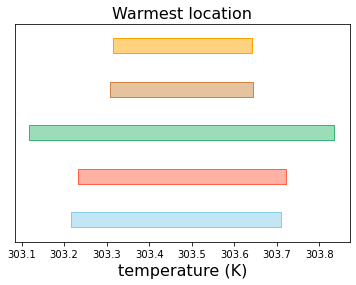

In [10]:
labels = ['conditional','hybrid','simultaneous','locally simultaneous','zoom']
plot_title = 'Warmest location'
xlabel = 'temperature (K)'
make_intervals([cond_int, hybrid_int, SI_int, LSI_int, zoom_int], labels, plot_title, xlabel, legend=False)
path = 'plots/warmest_location.pdf'
plt.savefig(path, bbox_inches='tight')